In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import dill

from sklearn.model_selection import train_test_split

import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Activation, Dense, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.models import Sequential
from keras import layers

import re
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


In [2]:
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ashra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ashra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ashra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Define Helper Functions

In [3]:
#Cleans Text
def normalizer(tweet):
    no_urls = re.sub(r"http\S+", " " ,tweet)
    only_letters = re.sub("[^a-zA-Z]", " ",no_urls)
    tokens = nltk.word_tokenize(only_letters)[2 :]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    #lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return filtered_result

#Generate Plots for Model
def plot_graphs(history, metric):
  plt.figure( figsize=(16,12))
  plt.rcParams.update({'font.size': 22})
  plt.plot(history.history[metric])
  #plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

#make a prediction on input text
def predict_on_text(text):
  
  test_text = np.array([text])
  test_df =  pd.DataFrame(test_text, columns = ['text'])

  test_df['normalized_tweet'] = test_df.text.apply(normalizer)
  X = test_df["normalized_tweet"].astype(str)

  df = token.texts_to_sequences(X)

  df = tf.keras.preprocessing.sequence.pad_sequences(df, maxlen=max_length)

  prediction = np.round(model.predict(df)[0][0])

  if prediction:

    return "This is about Sports."

  else:

    return "This is not about Sports."

# compute accuracy
def accuracy(y, y_hat):

  acc = np.mean(y == y_hat)

  print('The accuracy is: ' + str(acc))

#generates confusion matrix
def confusionMatrix(ys,preds):
    
    N = len(ys)
    #Generate empty matrix
    confuse = np.zeros((2,2),dtype=int)
    
    #loop through both arrays
    for i in range(N):
    
      #increase count in entry of each label
      confuse[ys[i],int(preds[i])] = confuse[ys[i],int(preds[i])] + 1
    
    #return as dataframe
    return pd.DataFrame(confuse)

## Data Reading and Cleaning

In [4]:
#uploaded = files.upload()

df = pd.read_csv("./data.csv")

#map data labels to 0 or 1 
df.label = df["label"].replace({"not_sports":0,"sports":1})

#add cleaned data to the DataFrame
df['normalized_tweet'] = df.title.apply(normalizer)

#seperate X and y out as DataFrames
X = df["normalized_tweet"].astype(str)
y = df["label"]

In [5]:
max_features = 50000 #we set maximum number of words to 5000
max_length = 200 #we set maximum sequence length to 400
embedding_dim = 100 

token = tf.keras.preprocessing.text.Tokenizer(num_words=max_features) 
token.fit_on_texts(X)

vocab_size = len(token.word_index) + 1 

#conver X to a TensorFlow Type and add padding
df = token.texts_to_sequences(X)
df = tf.keras.preprocessing.sequence.pad_sequences(df, maxlen=max_length)


## Split Data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df, y,test_size=0.15,random_state=101)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=1)

## Model Building

In [7]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=max_length))
# model.add(layers.Flatten())
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid',kernel_initializer='uniform'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          1325600   
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,326,621
Trainable params: 1,326,621
Non-trainable params: 0
_________________________________________________________________


## Save, Load and Train Model

In [8]:
history = model.fit(np.array(X_train), np.array(y_train), batch_size=52,epochs=10) 

Epoch 1/10
178/178 [==============================] - 4s 22ms/step - loss: 0.6134 - accuracy: 0.7678
Epoch 2/10
178/178 [==============================] - 4s 22ms/step - loss: 0.2513 - accuracy: 0.9207
Epoch 3/10
178/178 [==============================] - 4s 22ms/step - loss: 0.1184 - accuracy: 0.9579 0s
Epoch 4/10
178/178 [==============================] - 4s 22ms/step - loss: 0.0763 - accuracy: 0.9710
Epoch 5/10
178/178 [==============================] - 4s 21ms/step - loss: 0.0615 - accuracy: 0.9735
Epoch 6/10
178/178 [==============================] - 4s 21ms/step - loss: 0.0547 - accuracy: 0.9752
Epoch 7/10
178/178 [==============================] - 4s 22ms/step - loss: 0.0528 - accuracy: 0.9761
Epoch 8/10
178/178 [==============================] - 4s 23ms/step - loss: 0.0520 - accuracy: 0.9752
Epoch 9/10
178/178 [==============================] - 4s 23ms/step - loss: 0.0492 - accuracy: 0.9763
Epoch 10/10
178/178 [==============================] - 4s 22ms/step - loss: 0.0505 - acc

In [9]:
model.evaluate(X_test,y_test)

57/57 [==============================] - 0s 3ms/step - loss: 0.2746 - accuracy: 0.8969


[0.2745616137981415, 0.8969128727912903]

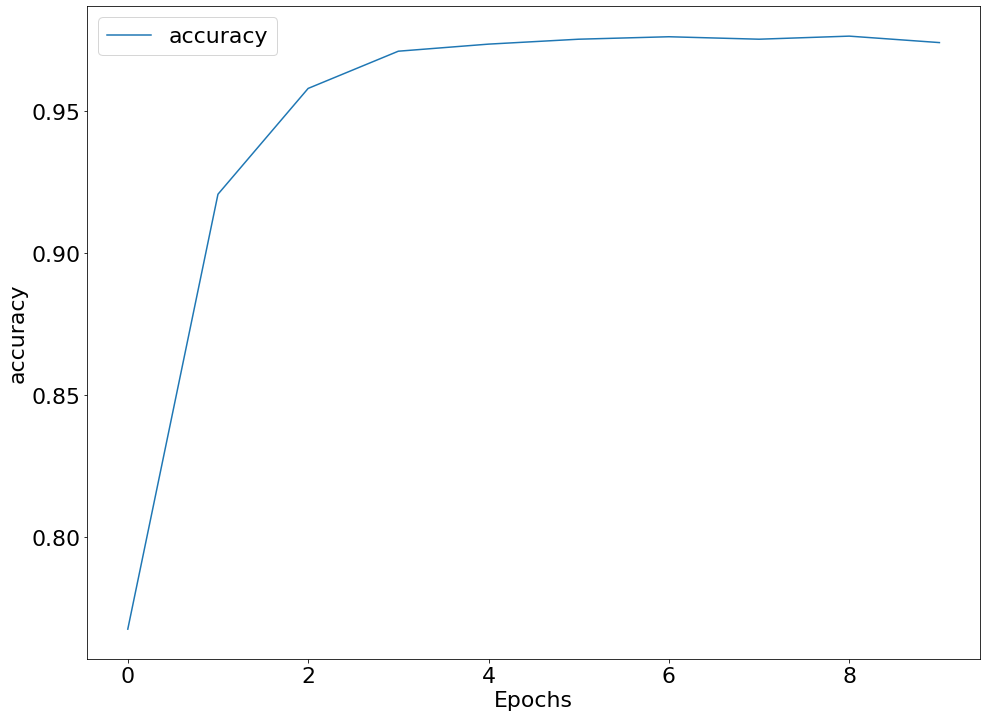

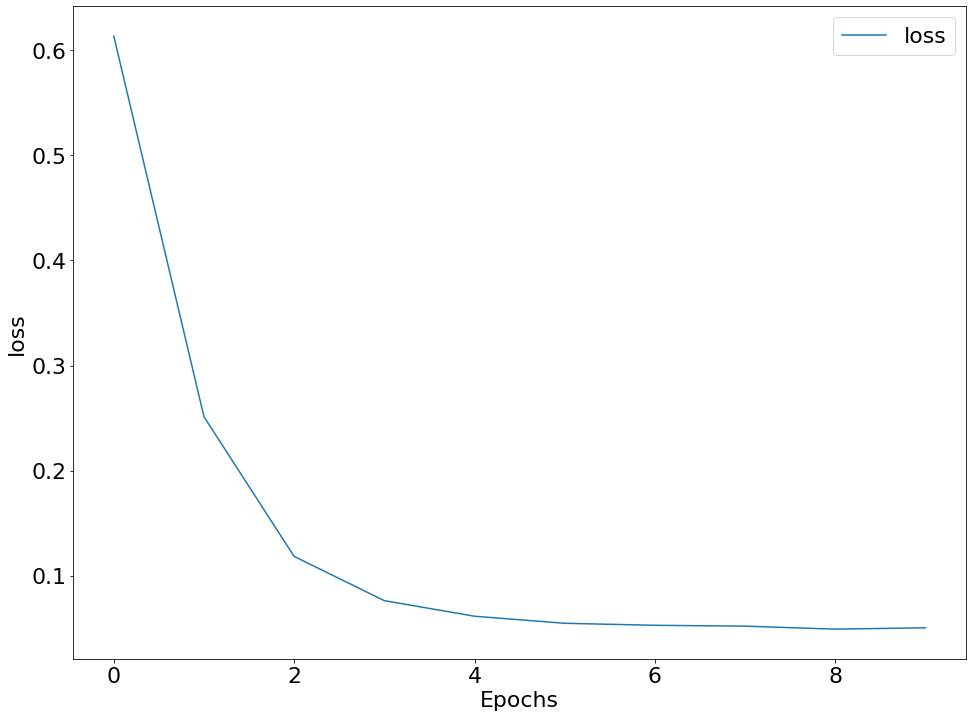

In [10]:
#plot graphs for training
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

## Model Testing and Metrics

In [11]:
#predict on test data
predictions = model.predict(X_test)
predictions = predictions.reshape((1814,))
predictions = np.round(predictions)

#accuracy on test data
accuracy(y_test , predictions)

The accuracy is: 0.8969128996692393


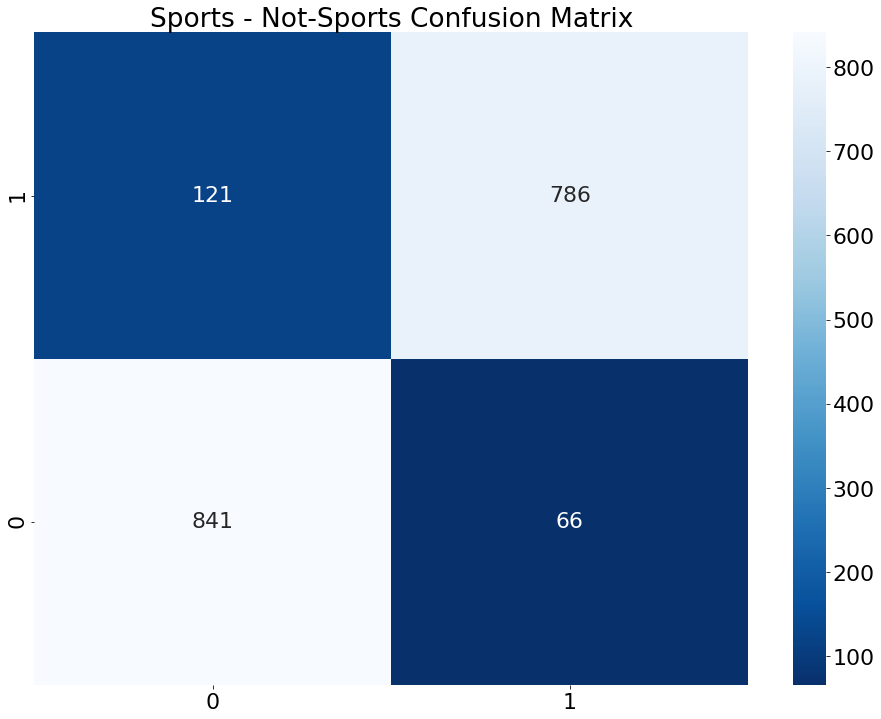

In [12]:
#Make Confusion Matrix
ys = y_test.to_numpy()
con = confusionMatrix(ys,predictions)
fig1 = plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size': 22})
ax = sns.heatmap(con, annot=True, cmap ='Blues_r' ,fmt='d')
plt.title("Sports - Not-Sports Confusion Matrix")
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.show()

In [13]:
#Calculate Specificity and Sensitivity 
con_mat = con.to_numpy()
tn = con_mat[0,0]
fn = con_mat[1,0]
fp = con_mat[0,1]
tp = con_mat[1,1]

sensitivity =  tp/(tp+fn)
specificity = tn /(tn+fp)

print('The sensitivity is: ' + str(sensitivity))
print('The specificity is: ' + str(specificity))

The sensitivity is: 0.8665931642778391
The specificity is: 0.9272326350606395


# Predict Model

In [14]:
test_text  = " is my favourite " 

print(predict_on_text(test_text))

This is about Sports.


In [19]:
model.save("C:/Users/ashra/Documents/Enhance IT/NLP_group/")

with open("token.pickle", 'wb') as f:

    dill.dump(token,f)

INFO:tensorflow:Assets written to: C:/Users/ashra/Documents/Enhance IT/NLP_group/assets
